In [6]:
# Main repo here for pytorch
# https://github.com/timesler/facenet-pytorch

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from facenet_pytorch import InceptionResnetV1

plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './faces/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print(dataset_sizes)

class_names = image_datasets['train'].classes

print(dataloaders['train'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using " + str(device))

sigmoid_fun = torch.nn.Sigmoid()


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(5)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = sigmoid_fun(outputs[:,0]) > 0.5
                    preds = preds.float()  
                    loss = criterion(outputs[:,0], labels.float())
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = InceptionResnetV1(pretrained='vggface2', device=device, classify= True, num_classes=2)

print(model_ft.logits)

model_ft = model_ft.to(device)

criterion = nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)
model_path = "trained_model.pt"
print("Saving model "+model_path)
torch.save(model_ft.state_dict(), model_path)


{'train': 30, 'val': 10}
Using cpu
Linear(in_features=512, out_features=2, bias=True)
Epoch 0/14
----------
train Loss: 0.7257 Acc: 0.6333
val Loss: 0.7867 Acc: 0.2000

Epoch 1/14
----------
train Loss: 0.6919 Acc: 0.5000
val Loss: 0.8414 Acc: 0.2000

Epoch 2/14
----------
train Loss: 0.6901 Acc: 0.5333
val Loss: 0.7903 Acc: 0.5000

Epoch 3/14
----------
train Loss: 0.6831 Acc: 0.5667
val Loss: 0.7729 Acc: 0.5000

Epoch 4/14
----------
train Loss: 0.6932 Acc: 0.5000
val Loss: 0.7533 Acc: 0.6000

Epoch 5/14
----------
train Loss: 0.6689 Acc: 0.6333
val Loss: 0.6899 Acc: 0.6000

Epoch 6/14
----------
train Loss: 0.6767 Acc: 0.5667
val Loss: 0.6933 Acc: 0.6000

Epoch 7/14
----------
train Loss: 0.6721 Acc: 0.5333
val Loss: 0.6711 Acc: 0.6000

Epoch 8/14
----------
train Loss: 0.6751 Acc: 0.6333
val Loss: 0.6619 Acc: 0.6000

Epoch 9/14
----------
train Loss: 0.6847 Acc: 0.5667
val Loss: 0.6895 Acc: 0.6000

Epoch 10/14
----------
train Loss: 0.6812 Acc: 0.5667
val Loss: 0.7023 Acc: 0.5000



In [26]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(inputs[0].shape)
            #use these lines for advnet
            outputs = model(inputs)
            outputs, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs)
            #print(probs)
            for j in range(inputs.size()[0]):
                print(preds)
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} w/ {round(float(probs[j] * 100),2)}%')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Iteration 0, Target class probability: tensor([0.5934, 0.6350])
Iteration 10, Target class probability: tensor([0.7283, 0.7393])
Iteration 20, Target class probability: tensor([0.8467, 0.8374])
Iteration 30, Target class probability: tensor([0.8993, 0.8914])
Iteration 40, Target class probability: tensor([0.9244, 0.9198])


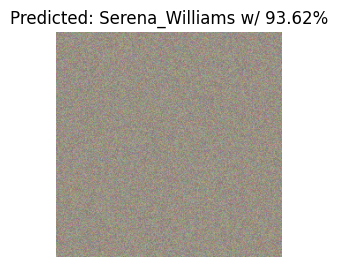

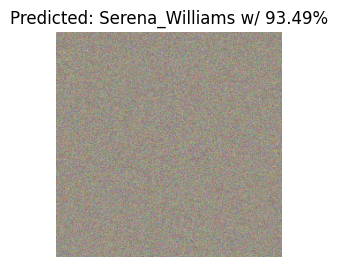

In [51]:
inputimg = torch.rand(2, 3, 256, 256, requires_grad=True)
optimizer = optim.SGD([inputimg], lr=0.01, momentum=0.9)
target_class = 1
num_iterations = 50  
for iteration in range(num_iterations):
    optimizer.zero_grad()  
    outputs = model_ft(inputimg)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    loss = -torch.log(probs[:, target_class]).sum()
    loss.backward()
    optimizer.step()    
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Target class probability: {probs[:, target_class].detach()}")

num_images = 2
images_so_far = 0
for j in range(inputimg.size(0)):
    images_so_far += 1
    ax = plt.subplot(num_images // 2, 2, images_so_far)
    ax.axis('off')
    output_class = torch.argmax(probs[j])
    ax.set_title(f'Predicted: {class_names[output_class]} w/ {round(float(probs[j, output_class] * 100), 2)}%')
    imshow(inputimg.cpu().data[j])

    if images_so_far == num_images:
        break


torch.Size([3, 299, 299])
tensor([0.3114, 0.1361, 0.2024, 0.3501])
tensor([0, 1, 0, 0])


/var/folders/2b/sgygl_kx5l33b6s82h9h_49w0000gn/T/ipykernel_16947/3255495638.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(outputs)


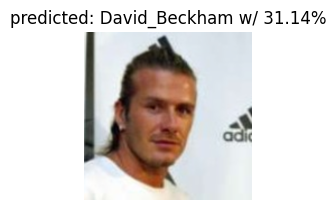

KeyboardInterrupt: 

In [27]:
visualize_model(model_ft)

#create a model that generates 3 by 256 by 256 images to act as an adversarial net

